<a href="https://colab.research.google.com/github/zachjoachim7/deep_learning_labs/blob/main/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](https://github.com/wingated/cs474_labs/blob/master/images/style1.png?raw=true)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function,
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from torch.nn.parameter import Parameter
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving content-image-mona-lisa.jpeg to content-image-mona-lisa (3).jpeg

Upload Style Image


Saving style-image-van-gogh.webp to style-image-van-gogh (1).webp
Content Path: <_io.BytesIO object at 0x7b3f43d7ea70>
Style Path: <_io.BytesIO object at 0x7b401710f920>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


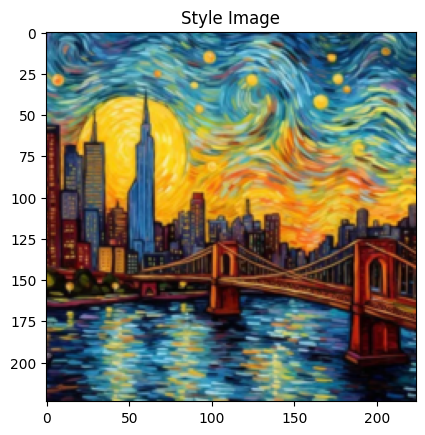

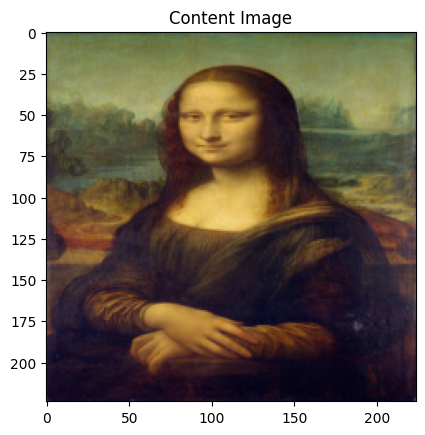

In [4]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
          m.inplace = False          # the model has a hard time going backwards on the in place functions.

        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
ccl1 = vgg_names.index('conv1_2')
chosen_content_layer = [ccl1]
csl1, csl2, csl3, csl4 = vgg_names.index('conv2_1'), vgg_names.index('conv2_2'), vgg_names.index('conv3_1'), vgg_names.index('conv3_2')
chosen_style_layer = [csl1, csl2, csl3, csl4]
# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
content_model = VGGIntermediate(requested=chosen_content_layer).cuda()
style_model = VGGIntermediate(requested=chosen_style_layer).cuda()
content_layers = content_model(content_image)
style_layers = style_model(style_image)
# Cache the outputs of the content and style layers for their respective images
content_layers = [content_layers[i] for i in content_layers]
style_layers = [style_layers[i] for i in style_layers]

<ipython-input-5-4e86d2def5ec>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-5-4e86d2def5ec>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior

___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**


In [7]:
def gram_matrix(input):
   b, c, h, w = input.size()  # batch, channel, height, width.
   x = input.view(b*c, h*w)
   gram = torch.mm(x, x.t())

   return gram.div(b * c * h * w)

class ContentLoss(nn.Module):
  def __init__(self, cont_image):
    super(ContentLoss, self).__init__()
    self.targ_image = cont_image.clone().detach()

  def forward(self, input_image):
    return F.mse_loss(input_image, self.targ_image)


class StyleLoss(nn.Module):
  def __init__(self, style_image):
    super(StyleLoss, self).__init__()
    self.gram_style = gram_matrix(style_image.clone().detach())

  def forward(self, input_img):
    gram = gram_matrix(input_img)
    return F.mse_loss(gram, self.gram_style)

# Instantiate a content loss module for each content layer
#  with the content reference image outputs for that layer for comparison

# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



<ipython-input-5-4e86d2def5ec>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-5-4e86d2def5ec>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch: 0, content_loss: 0.0, style_loss: 26918.84375
Epoch: 50, content_loss: 75.23423767089844, style_loss: 212.33424377441406
Epoch: 100, content_loss: 68.02042388916016, style_loss: 91.1143569946289
Epoch: 150, content_loss: 66.13031005859375, style_loss: 107.68710327148438
Epoch: 200, content_loss: 81.39794921875, style_loss: 441.00079345703125
Epoch: 250, content_loss: 75.12828063964844, style_loss: 148.2633514404297
Epoch: 300, content_loss: 68.8594970703125, style_loss: 58.90968322753906
Epoch: 350, content_loss: 72.13822174072266, style_loss: 352.8234558105469
Epoch: 400, content_loss: 85.56304931640625, style_loss: 515.6204833984375
Epoch: 450, content_loss: 83.11213684082031, style_loss: 373.8573913574219


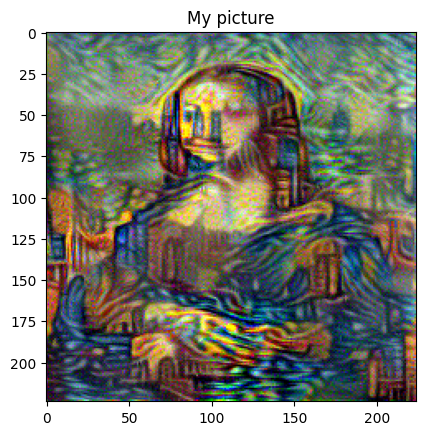

In [8]:
# Start with a copy of the content image
copy_content_image = content_image.clone().detach().requires_grad_(True)

# Set the optimizer to update the image
optimizer = optim.Adam([copy_content_image], lr=0.1)
# (Set requires_grad to True on the image to allow it to accumulate a gradient)
model = VGGIntermediate(requested=chosen_content_layer + chosen_style_layer).cuda()

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors
num_epochs = 500
alpha = 10
beta = 250000

content_losses = [ContentLoss(l) for l in content_layers]
style_losses = [StyleLoss(l) for l in style_layers]
for epoch in range(num_epochs):
  optimizer.zero_grad()

  my_model = model(copy_content_image)
  total_content_loss = 0
  total_style_loss = 0
  for i in range(len(content_losses)):
    total_content_loss += content_losses[i](my_model[chosen_content_layer[i]])
  for i in range(len(style_losses)):
    total_style_loss += style_losses[i](my_model[chosen_style_layer[i]])

  total_content_loss *= alpha
  total_style_loss   *= beta

  total_loss = total_content_loss + total_style_loss
  total_loss.backward()
  optimizer.step()

  if epoch % 50 == 0:
    print(f"Epoch: {epoch}, content_loss: {total_content_loss}, style_loss: {total_style_loss}")


# Show the image
display(torch.clamp(copy_content_image, min=0, max=1), title="My picture")

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts. \\
Equation 1 is given by: $\mathscr{L}_{content} (\overrightarrow{p}, \overrightarrow{x}, \overrightarrow{l}) = \frac{1}{2} \sum_{i,j} (F_{ij}^l - P_{ij}^l)^2$. This is the equation for content loss, where $\overrightarrow{p}$ is the content image, $\overrightarrow{x}$ is the image we are creating, and $\overrightarrow{l}$ is the layer we are computing the loss for. This equation is also the L2 norm. When all of the layers $l$ are passed through the VGG network, $F_{ij}^l$ becomes a list of all the activation maps for the generated image. For this variable, $i$ represents the numbers of filters from layer $l$ on pixel $j$. When all of the layers $l$ are passed through the VGG network, $P_{ij}^l$ becomes a list of all the activation maps for the content image. The $i,j$ and $l$ are the same as above.

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts. \\
Equation 3 is given by: $G_{ij}^l = \sum_{k} F_{ik}^l F_{jk}^l$. This is the gram matrix. The gram matrix is the inner product on layer $l$ between the feature maps $i$ and $j$ (in vector form). $F_{ik}^l$ and $F_{jk}^l$ are parallel to $F_{ij}^l$ from the above equation. The gram matrix tells us how similar all of the activation maps are. The easiest way to calculate the gram matrix is $FF^T$.

- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts. \\
Equation 4 is given by: $E_{l} = \frac{1}{4N_{l}^2M_{l}^2}\sum_{ij}(G_{ij}^l - A_{ij}^l)^2$. In this equation, $E_l$ is the contribution of layer $l$ to the total loss. $N_l$ is the number of channels for each feature map in layer $l$. $M_l$ is the $height * width$ for each feature map in the layer. $G_{ij}^l$ is the style representation matrix for the generated image $\overrightarrow{x}$. $A_{ij}^l$ is the style representation matrix for the style image $\overrightarrow{a}$. Here we just iterate over both representations, getting and calculating their loss and adding that to the total loss for the layer.

- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
Equation 5 is given by: $\mathscr{L}_{style}(\overrightarrow{a}, \overrightarrow{x}) = \sum_{l=0}^{L} w_lE_l$. This is very similar to equation (1) except it calculates the style loss between the style image $\overrightarrow{a}$ and the generated image $\overrightarrow{x}$. Here, $w_l$ representes the weight factor contribution of every level and $E_l$ is just the contribution of that layer $l$ from equation (4).

**DONE:**